In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import multiprocessing
print(f'cpu count: {multiprocessing.cpu_count()}')
import numpy as np
import numpy.typing as npt
from tqdm import tqdm
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation as fws

cpu count: 128


In [2]:
def get_spectral_error(g, W, Cxx):
    N = W.shape[0]
    Ixx = np.eye(N)
    WGW = W @ np.diag(g) @ W.T
    M = np.linalg.inv(Ixx + WGW)
    Cyy = M @ Cxx @ M.T
    eigvals = np.linalg.eigvalsh(Cyy)
    spectral_error = np.linalg.norm(eigvals - 1)**2
    return spectral_error

def simulate_one(
    n: int, 
    eta_g: float, 
    n_batch: int, 
    frame: str,
    seed: int,
):
    """Simulate one run of whitening algorithm with random cov and given frame."""
    assert frame in ["GRASSMANN", "RANDN", "SPECTRAL", "SPECTRAL_FRAME"]
    np.random.seed(seed)
    # setup
    k = n * (n + 1) // 2
    rng = np.random.default_rng(seed=seed)
    s = np.exp((np.linspace(-3, 3, n) + rng.standard_normal((n, )))*.1) 
    # s = np.exp(rng.uniform(.1, 1, (n, )) + rng.standard_normal((n, ))*.1)

    Q0,_ = np.linalg.qr(rng.standard_normal((n, n)))

    Cxx =  Q0@np.diag(s)@Q0.T   # COV
    M_init = np.eye(n) * 1

    # in R2 and R3, equiangular frames are known.
    if frame == "GRASSMANN":
        if n > 3:
            W, _ = fw.design_grassmannian(n, k, rng=rng)
        elif n == 2:
            Q, _ = np.linalg.qr(rng.standard_normal((n, n)))
            W = Q @ fw.get_mercedes_frame() 
            # W, _ = design_grassmannian(n, k, rng=rng)
        else: # n == 3
            Q, _ = np.linalg.qr(rng.standard_normal((n, n)))
            W = Q @ fw.get_equiangular_3d()
            # W, _ = design_grassmannian(n, k, rng=rng)
    elif frame == "RANDN":
        W = rng.standard_normal((n, k))
    elif frame == "SPECTRAL_FRAME":
        W = np.concatenate([Q0, rng.standard_normal((n, k-n))], 1)
    else:  # spectral
        W = Q0

    W = fw.normalize_frame(W)
    g0 = fws.get_g_opt(W, M_init)

    online = False
    # online = True
    batch_size = 1
    g_last, g_all, errors, _ = fws.adapt_covariance(
        [Cxx], W, batch_size, n_batch, eta_g, g0, online, False, 1., 
        verbose=False, break_on_convergence=False, seed=seed, error_type='operator',
        )

    return errors, g_all, W, Cxx

def simulate_many(
    n: int,
    n_steps: int,
    n_repeats: int, 
    lr: float,
    frame: str,
) -> npt.NDArray[np.float64]:
    """Run all simulations in parallel."""

    with multiprocessing.Pool() as pool:
        all_errors = []
        pbar = tqdm(total=n_repeats)
        for output in pool.starmap(simulate_one, [(n, lr, n_steps, frame, i) for i in range(n_repeats)]):
            errors, _, _, _ = output
            if len(errors) != n_steps:
                errors = errors + [errors[-1]] * (n_steps - len(errors))
            all_errors.append(errors)
            pbar.update(1)
    all_errors = np.array(all_errors)
    return all_errors

In [3]:
n_repeats = 100
n = 2
n_steps = 100_000

lr = 1E-2
# lr = 1E-4
all_errors_randn = simulate_many(n, n_steps, n_repeats, lr, "RANDN")
all_errors_grassmann = simulate_many(n, n_steps, n_repeats, lr, "GRASSMANN")
all_errors_spectral = simulate_many(n, n_steps, n_repeats, lr, "SPECTRAL")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.20it/s]


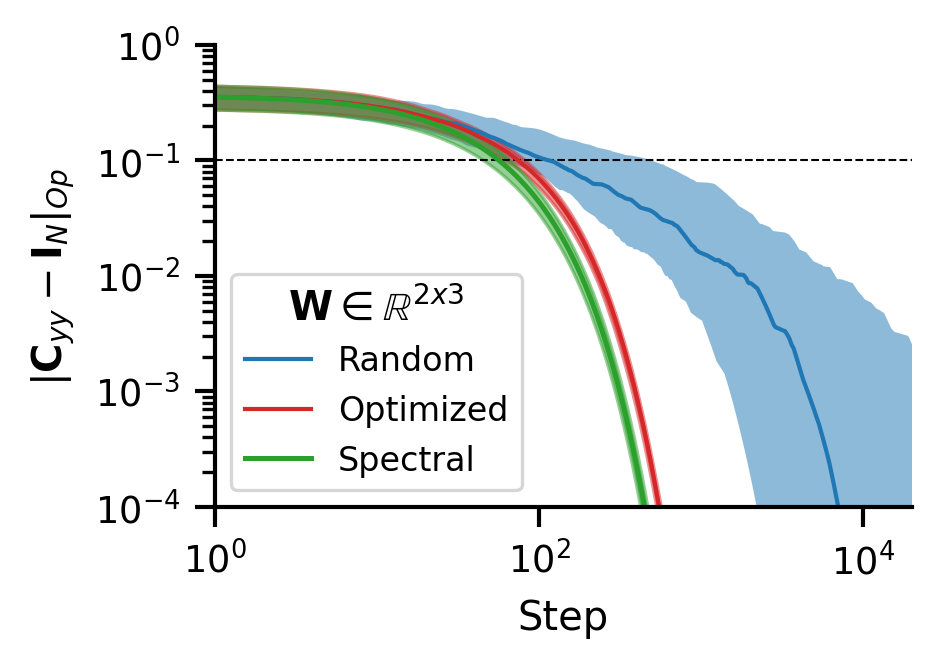

In [7]:
# fmt: off
def get_mu_lo_hi(x):
    """Gets avg, lower, upper bound for errorbars"""
    sigma = np.std(x, axis=0) / np.sqrt(x.shape[0])
    # mu = np.mean(x, axis=0)
    mu = np.median(x, axis=0)

    return mu, (np.quantile(x, .25, axis=0), np.quantile(x, .75, axis=0))
    # return mu, (mu - sigma, mu + sigma)
    
with sns.plotting_context("paper", font_scale=1):
    fig0, ax = plt.subplots(1, 1, figsize=(3, 2) ,dpi=300)

    mu_randn, sig_randn = get_mu_lo_hi(all_errors_randn)
    mu_opt, sig_opt = get_mu_lo_hi(all_errors_grassmann)
    mu_spectral, sig_spectral = get_mu_lo_hi(all_errors_spectral)

    ax.hlines(1E-1, 1, n_steps, linestyles="dashed", color="k", linewidth=0.5)
    ax.plot(range(1, len(mu_randn)+1), mu_randn, color="C0", label="Random", linewidth=1)
    # ax.fill_between(range(1, len(mu_randn)+1), sig_randn[0], sig_randn[1], alpha=0.5)
    ax.fill_between(range(1, len(mu_randn)+1), *sig_randn, alpha=0.5)

    ax.plot(range(1, len(mu_opt)+1), mu_opt, color="C3", label="Optimized", linewidth=1)
    ax.fill_between(range(1, len(mu_opt)+1),  sig_opt[0], sig_opt[1], color="C3", alpha=0.5)

    ax.plot(range(1, len(mu_spectral)+1), mu_spectral, color="C2", label="Spectral")
    ax.fill_between(range(1, len(mu_spectral)+1),  sig_spectral[0],  sig_spectral[1], color="C2", alpha=0.5)

    ax.set(yscale="log", 
    xscale="log", 
    # ylabel=r"$\frac{1}{N^2}\|{\bf C}_{yy} - {\bf I}_N\|_F^2$", 
    ylabel=r"$\|{\bf C}_{yy} - {\bf I}_N\|_{Op}$", 
    xlabel="Step", 
    # xticks=(1, n_steps), 
    # xticks=np.arange(0, n_steps+1, (n_steps+1)//4),
    # xticklabels=np.arange(0, (n_steps)//10+1, (n_steps+1)//40),
    xlim=(1, n_steps),
    ylim=(1E-4, 1E-0),
    )
    kn = n * (n + 1) // 2 
    ax.legend(title=r"${\bf W}\in \mathbb{R}^{" + f"{n}x{kn}" + r"}$",
               loc="lower left", fontsize=8)

    sns.despine()
# fmt: on

In [5]:
seed = 42069
n = 2
n_steps = 20_000
_, g_all_randn, W_randn, Cxx_randn = simulate_one(n, lr, n_steps, "RANDN", seed)
_, g_all_opt, W_opt, Cxx_opt = simulate_one(n, lr, n_steps, "GRASSMANN", seed)
_, g_all_spectral, W_spectral, Cxx_spectral = simulate_one(n, lr, n_steps, "SPECTRAL", seed)

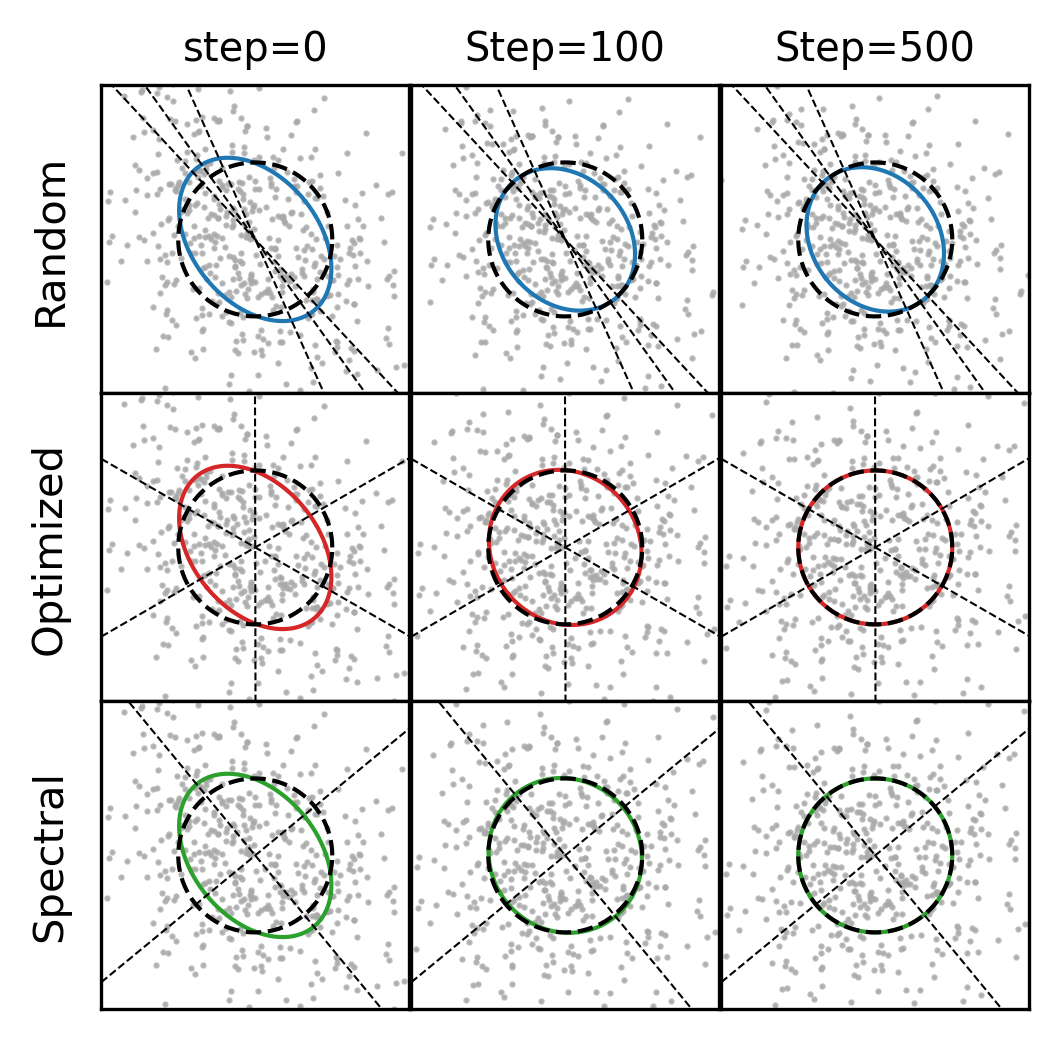

In [11]:
import frame_whitening.plot as fwplt

def plot_cyy(W, g, Cxx, ax, **kwargs):
    rng = np.random.default_rng(0)
    X = rng.standard_normal((500, 2))
    M = np.linalg.inv(np.eye(2) + W @ np.diag(g) @ W.T) 
    Cyy = M @ Cxx @ M.T
    X = X @ np.linalg.cholesky(Cyy).T
    fwplt.plot_ellipse(Cyy, ax=ax, stdev=1, linewidth=1, **kwargs)
    fwplt.plot_ellipse(np.eye(2), ax=ax, color="k", linestyle="dashed", linewidth=1, stdev=1)

    ax.scatter(X[:, 0], X[:, 1], s=.5, color="darkgrey", alpha=0.8)
    lims = (-2.0, 2.0)
    x = np.linspace(*lims, 100)
    for i in range(W.shape[1]):
        # plot sloped lines corresponding to columns of W
        w = W[:, i]
        ax.plot(x, (w[1] / w[0]) * x, color="k", linewidth=0.5, linestyle="dashed")

    ax.axis("square")
    ax.set(xlim=lims, ylim=lims, xticks=[], yticks=[])

fig1, ax = plt.subplots(3, 3, figsize=(4, 4), dpi=300, sharex='all', sharey='all')
ax = ax.flatten()

t0, t1, t2 = 0, 100, 500
with sns.plotting_context("paper"):
    plot_cyy(W_randn, g_all_randn[t0], Cxx_randn, ax=ax[0])
    plot_cyy(W_randn, g_all_randn[t1], Cxx_randn, ax=ax[1])
    plot_cyy(W_randn, g_all_randn[t2], Cxx_randn, ax=ax[2])

    plot_cyy(W_opt, g_all_opt[t0], Cxx_opt, ax=ax[3], color="C3")
    plot_cyy(W_opt, g_all_opt[t1], Cxx_opt, ax=ax[4], color="C3")
    plot_cyy(W_opt, g_all_opt[t2], Cxx_opt, ax=ax[5], color="C3")

    plot_cyy(W_spectral, g_all_spectral[t0], Cxx_spectral, ax=ax[6], color="C2")
    plot_cyy(W_spectral, g_all_spectral[t1], Cxx_spectral, ax=ax[7], color="C2")
    plot_cyy(W_spectral, g_all_spectral[t2], Cxx_spectral, ax=ax[8], color="C2")

    ax[0].set(ylabel="Random", title=f"step={t0}")
    ax[1].set(title=f"Step={t1}")
    ax[2].set(title=f"Step={t2}")
    ax[3].set(ylabel="Optimized")
    ax[6].set(ylabel="Spectral")

    # remove white space between plots
    fig1.subplots_adjust(wspace=0, hspace=0)


In [12]:
# save figs as multipage pdf
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("figures/icml2023/3_convergence_rate.pdf") as pdf: 
    pdf.savefig(fig0, bbox_inches="tight", transparent=True)
    pdf.savefig(fig1, bbox_inches="tight", transparent=True)